# Tutorial 3-2 - Regression and Dimensionality Reduction

This tutorial repeats the same scenario as in Tutorial 3-1, but this time we train a regression model, i.e. a model for numeric prediction. We also add a dimensionality reduction element to the training pipeline. Note that dimensionality reduction can also be included in a classification pipeline.

We use the `fish market` dataset (see https://www.kaggle.com/datasets/vipullrathod/fish-market). Each example in this dataset represents a fish. The first column is the name of the fish species and the other six columns are numerical characteristics of the fish.

We aim to train a regression model for predicting the weight of a fish from its other characteristics. We evaluate two regression algorithms, `RandomForestRegressor` and `LinearRegression`, to choose the better one for training the final model.

In [4]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import (ColumnTransformer, TransformedTargetRegressor)
from sklearn.base import (BaseEstimator, TransformerMixin)
from sklearn.preprocessing import (StandardScaler, RobustScaler, OneHotEncoder, FunctionTransformer)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## EDA

We start with a brief EDA to check for missing values and outliers.

In [7]:
df = pd.read_csv("./fish.csv")
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [8]:
df.tail()

,Species,Weight,Length1,Length2,Length3,Height,Width
154,Smelt,12.2,11.5,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,11.7,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,12.1,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,13.2,14.3,15.2,2.8728,2.0672
158,Smelt,19.9,13.8,15.0,16.2,2.9322,1.8792


Let's examine values in the categorical column `Species` first.

In [10]:
df['Species'].value_counts()

Species
Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: count, dtype: int64

Now, let's check for missing values and outliers.

In [16]:
df.isna().sum()

Species    0
Weight     0
Length1    0
Length2    0
Length3    0
Height     0
Width      0
dtype: int64

There are no obvious missing values. Let's also examine the basic statistics of the numerical attributes.

In [19]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


They all look OK, except the minimum value for `Weight` which is 0. It must be a missing value represented by 0. Let's find out how many data rows have `Weight=0`.

In [22]:
df[df.Weight == 0]

,Species,Weight,Length1,Length2,Length3,Height,Width
40,Roach,0.0,19.0,20.5,22.8,6.4752,3.3516


It is just one data row. We drop it later as it cannot be used for training or testing. The regression model that we will train, though, can be used to predict the weight of this fish.

Next, let's check for outliers in the numerical columns. Based on the table above we can try to plot all numerical column except `Weight` together.

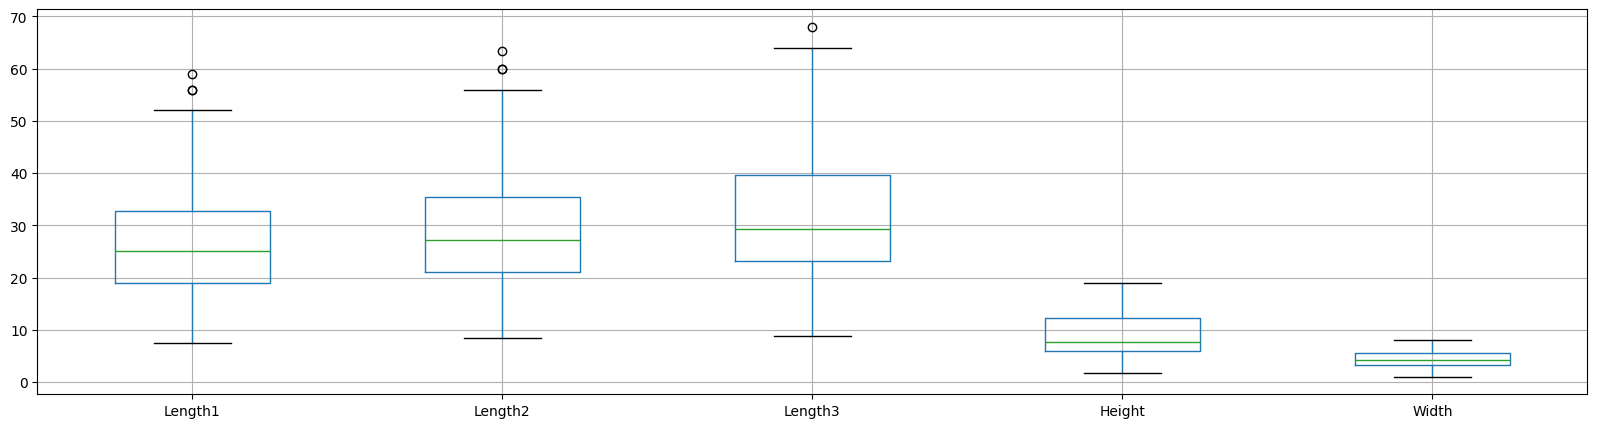

In [26]:
df.drop('Weight', axis=1).boxplot(figsize=(20,5))
plt.show()

There are some outliers in the `length` columns. We will apply RobustScaler to them and StandardScaler to `Height` and `Width`. Let's also examine the histograms of all attribtes.

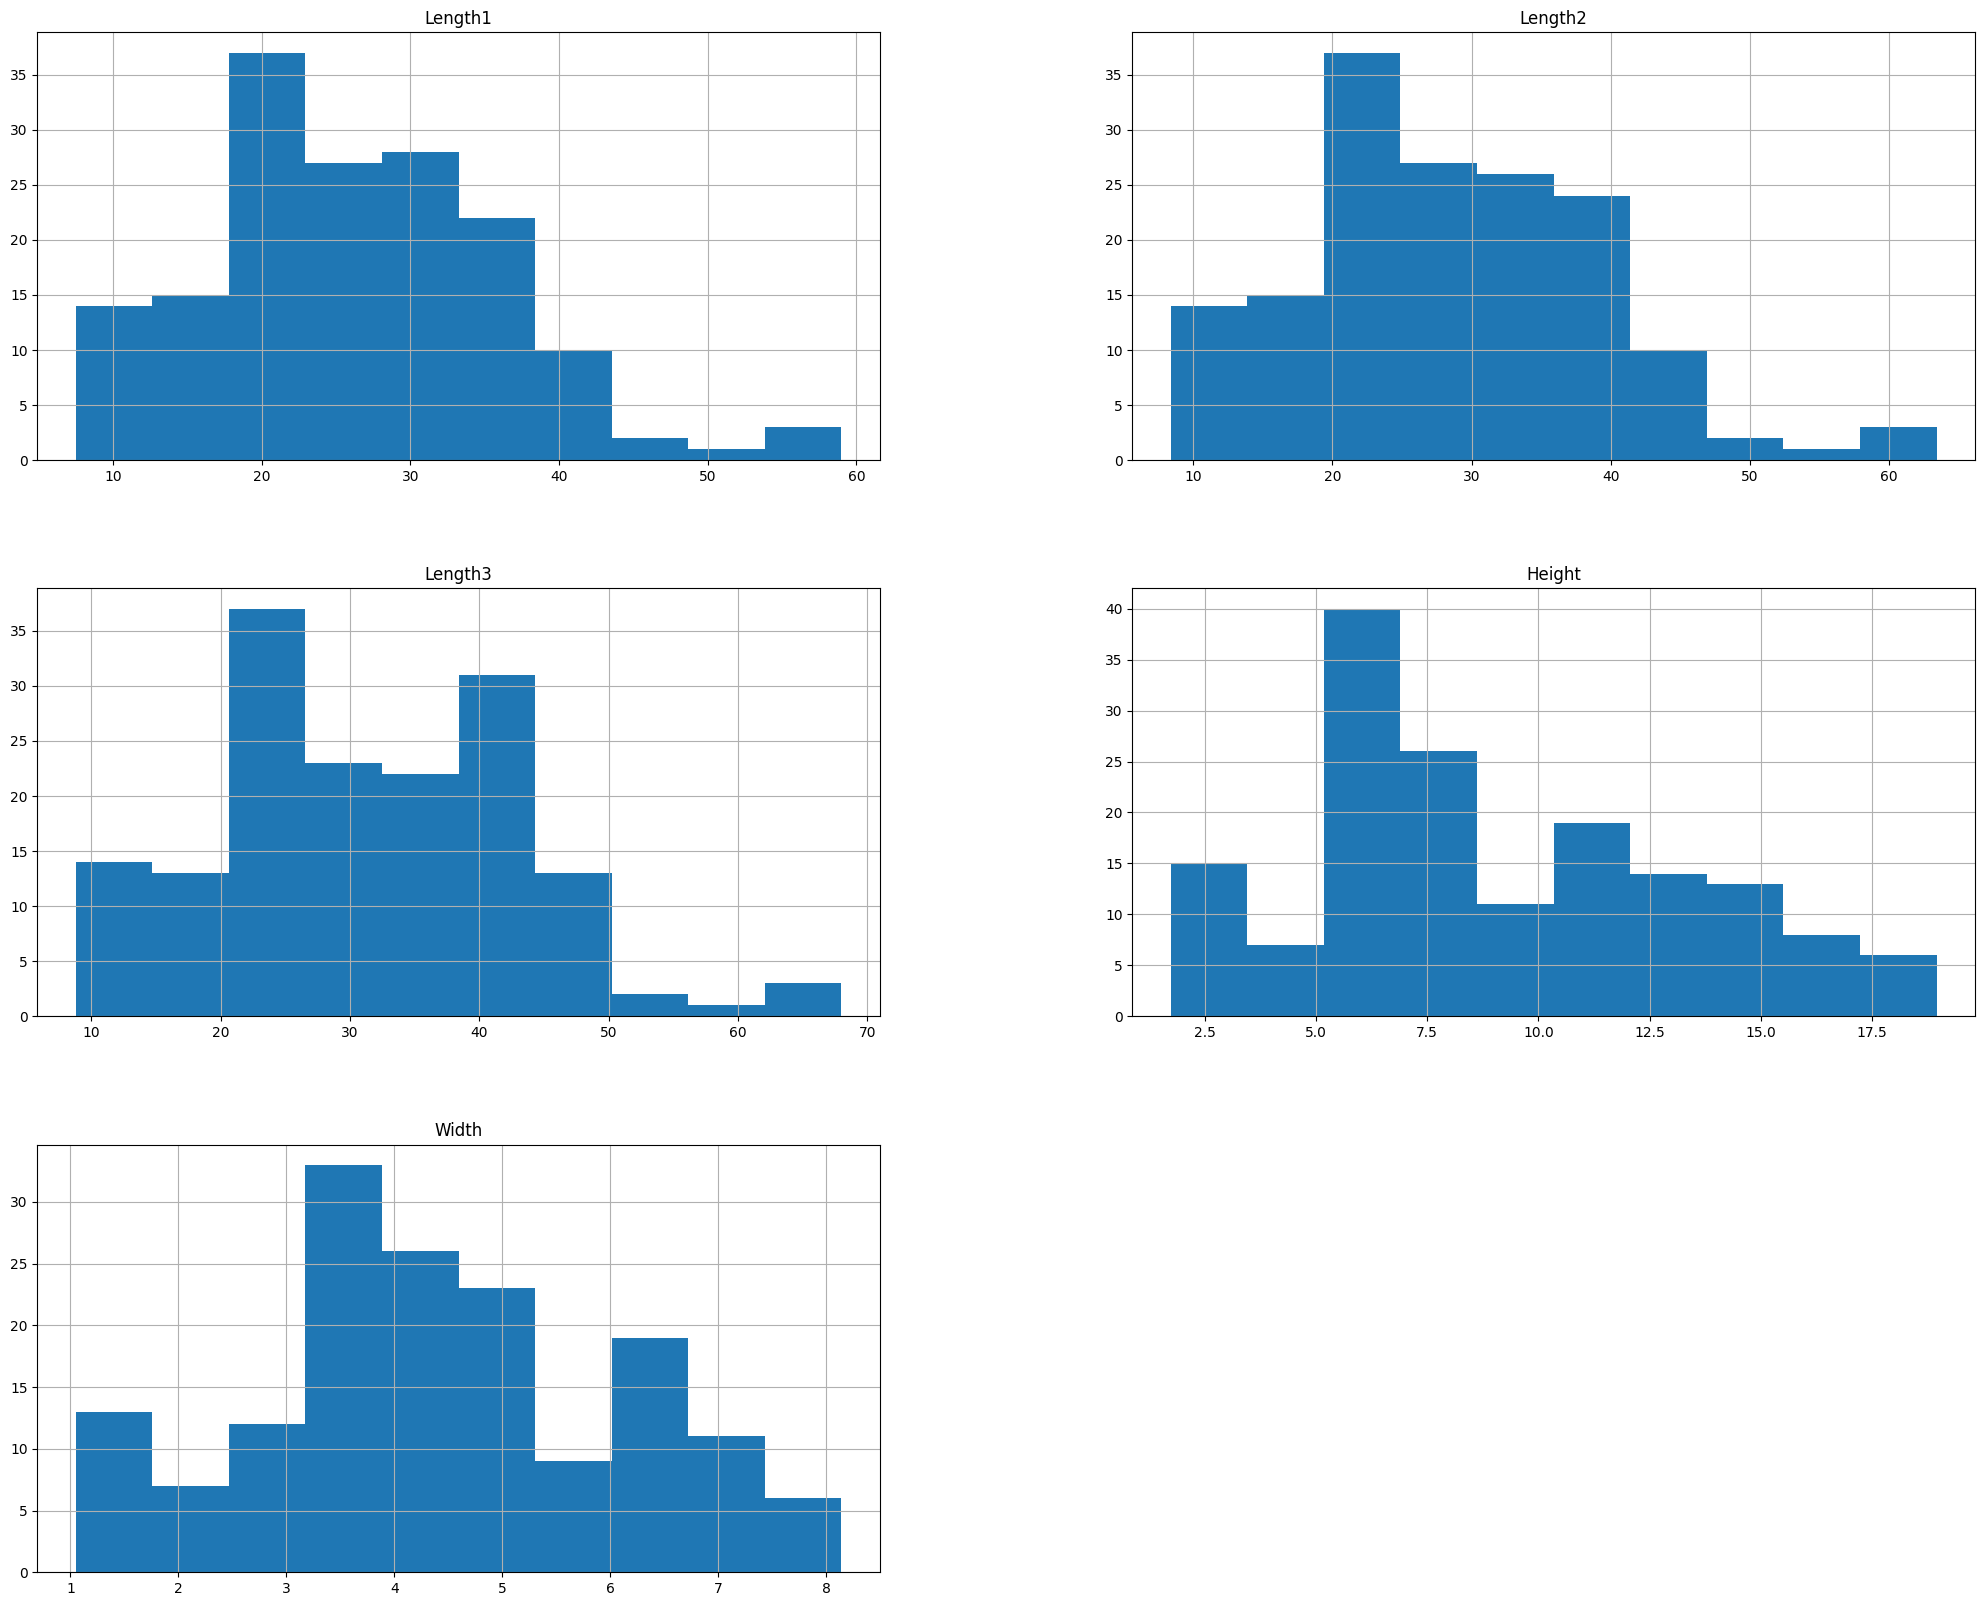

In [29]:
df.drop('Weight', axis=1).hist(bins=10, figsize=(25, 20));

The histograms above show a relatively close-to-normal distribution for all five numerical predictors. Thus, we won't apply a logarithmic or cubic root transformation to them.

Next, let's examine the `Weight` column which is the target of the regression model we are about to train

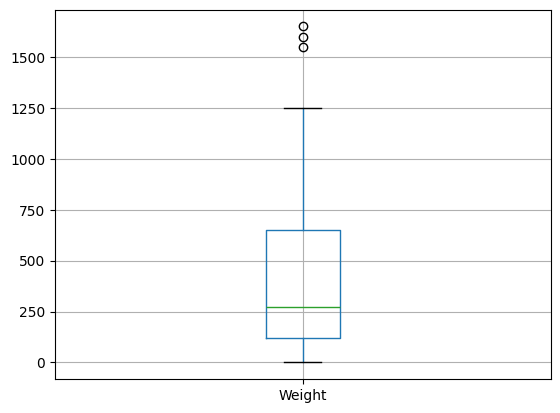

In [33]:
df.boxplot(column=['Weight'])
plt.show()

The three examples shown as outliers are in fact acceptable. A fish can weight 1650g, which is the maximum value of `Weight`.

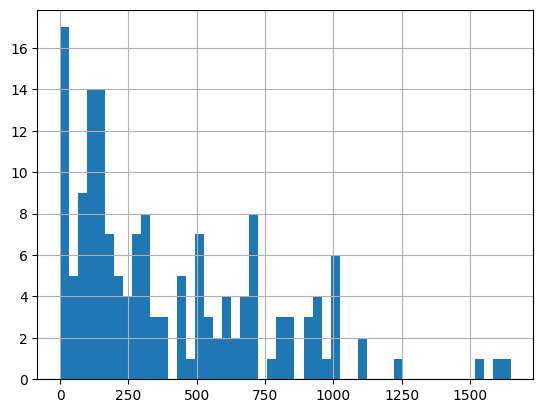

In [36]:
df['Weight'].hist(bins=50)
plt.show()

The target variable `Weight` is skewed to the right. Depending on the regression model we train, we may want to apply a logarithmic transformation to it.

## Data Preparation

First, let's drop the data row with weight 0.

In [41]:
df = df.drop(df[df.Weight == 0].index)

Next we split the columns into a target *`y`* and predictors *`X`*.

In [44]:
y = df['Weight']
X = df.drop('Weight', axis=1)

Next, similar to the classification tutorial, we build a data preprocessing pipeline that applies one-hot encoding to the `Species` column and scalers to the numerical predictors as discussed above. The transformation of the target will be done later when we build the main pipeline.

In [47]:
preprocess_pipeline = ColumnTransformer(
    transformers = [
        ("no_outliers", StandardScaler(), ['Height', 'Width']),
        ("categorical", OneHotEncoder(drop='first', sparse_output=False), ['Species'])
    ],
    remainder=RobustScaler() # i.e. ['Length1', 'Length2', 'Length3']
).set_output(transform="pandas") 

# The output of preprocess_pipeline is set to "pandas", 
# so we can view the output of the pipeline as a dataframe with 
# the names of the columns. We do this just as a test in the next few cells. 
# Otherwise, the output would be a numpy array.

Let's train the preprocessing pipeline on the predictors just to test if it does what we expect it to do.

In [50]:
X_transformed = preprocess_pipeline.fit_transform(X);

In [52]:
X_transformed.head()

,no_outliers__Height,no_outliers__Width,categorical__Species_Parkki,categorical__Species_Perch,categorical__Species_Pike,categorical__Species_Roach,categorical__Species_Smelt,categorical__Species_Whitefish,remainder__Length1,remainder__Length2,remainder__Length3
0,0.591654,-0.240092,0.0,0.0,0.0,0.0,0.0,0.0,-0.154982,-0.135593,0.018209
1,0.815870,-0.070461,0.0,0.0,0.0,0.0,0.0,0.0,-0.095941,-0.074576,0.091047
2,0.792000,0.161475,0.0,0.0,0.0,0.0,0.0,0.0,-0.103321,-0.061017,0.084977
3,0.874260,0.018572,0.0,0.0,0.0,0.0,0.0,0.0,0.073801,0.108475,0.230653
4,0.807462,0.421564,0.0,0.0,0.0,0.0,0.0,0.0,0.088561,0.108475,0.261002


In [54]:
X_transformed.tail()

,no_outliers__Height,no_outliers__Width,categorical__Species_Parkki,categorical__Species_Perch,categorical__Species_Pike,categorical__Species_Roach,categorical__Species_Smelt,categorical__Species_Whitefish,remainder__Length1,remainder__Length2,remainder__Length3
154,-1.610713,-1.800030,0.0,0.0,0.0,0.0,1.0,0.0,-1.018450,-1.030508,-0.989378
155,-1.531396,-1.874035,0.0,0.0,0.0,0.0,1.0,0.0,-1.003690,-1.016949,-0.983308
156,-1.567130,-1.881876,0.0,0.0,0.0,0.0,1.0,0.0,-0.974170,-0.976271,-0.965099
157,-1.427976,-1.399948,0.0,0.0,0.0,0.0,1.0,0.0,-0.892989,-0.888136,-0.880121
158,-1.414103,-1.511610,0.0,0.0,0.0,0.0,1.0,0.0,-0.848708,-0.840678,-0.819423


Now, let's split the original dataset into a training and test datasets.

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

## Grid Search for Best Parameters and Best Dimensionality Reduction Method

Next, we train `RandomForestRegressor` on the training set with a range of possible parameters in order to find the best parameters by cross-validation. To do this we build the main pipeline, which includes the preprocessing pipeline and `RandomForestRegressor`. We also add an element for dimensionality reduction after the preprocessing pipeline.

Here we attempt three different dimensionality reduction methods and we let the grid search pick the best one. These are:

- Principal Component Analysis (PCA)
- Recursive Feature Elimination (RFE) with estimator `svm.SVR`
- Recursive Feature Elimination (RFE) with estimator `LinearRegression`

Note that RFE is using a regression algorithm for selecting the best features. This regression algorithm can be different from the regression algorithm at the end of the main pipeline.

The main pipeline takes care of separately preprocessing the training and validation sets after the training set is further split into training and validation sets in the process of cross-validation. It also applies the dimensionality reduction method separately to the two sets.

### Random Forest Pipeline

The pipeline contains a placeholder for the dimensionality reduction method. We treat the dimensionality reduction method as a parameter and let the grid search pick the best of the three methods.

In [63]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=RandomForestRegressor(n_estimators=10),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

We limit the parameter grid to a few options for the `max_depth` parameter of `RandomForestRegressor` and to three alternative values for the number of selected features by the dimensionality reduction method. More parameters and values can be explored. Here we limit the options to make sure the grid search does not take too long to execute. Note that we also apply a logarithmic transformation to the target variable `Weight`.

In [66]:
N_FEATURES_OPTIONS = [2, 6, 11]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.942:
Best parameters:  {'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 11, 'ttr__regressor__max_depth': 6}


The parameter `refit=True` makes the `GridSearchCV` train a `RandomForestRegressor` model on the **whole training set** with the best parameters and the best dimensionality reduction method found. This best model can then be accessed via the `.best_estimator_` attribute of the `GridSearchCV`.

Let's repeat the same experiment but with `LinearRegression` for training a regression model.

### Linear Regression Pipeline

In [69]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('ttr', TransformedTargetRegressor(
                           regressor=LinearRegression(),
                           func=np.log, 
                           inverse_func=np.exp)
                       )
                      ]
               )

Again we limit the parameter grid to one parameter of `LinearRegression` and three alternative values for the number of selected features to make sure the grid search does not take too long to execute.

In [71]:
N_FEATURES_OPTIONS = [2, 6, 11]
FIT_INTERCEPT_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'ttr__regressor__fit_intercept': FIT_INTERCEPT_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.757:
Best parameters:  {'reduce_dim': PCA(iterated_power=7), 'reduce_dim__n_components': 6, 'ttr__regressor__fit_intercept': True}


The results suggest that Random Forest performs better. The cross-validation score is `1 - relative squared error`. The higher the score the more accurate the model. We can now further confirm this by comparing the best models on the test set.

## Compare Regression Models on Test Set

Now we can evaluate the best models found by the grid search on the test dataset and compare their metrics:

- mean squared error (MSE)
- mean absolute error (MAE)
- 1-relative squared error (R2)

to choose the better regressor for our problem.

In [75]:
# model - a trained regression model

def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

We use the function above to evaluate the best Random Forest and Linear Regression models found by the grid search.

In [77]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

We use a Pandas bar plots to compare the results. 

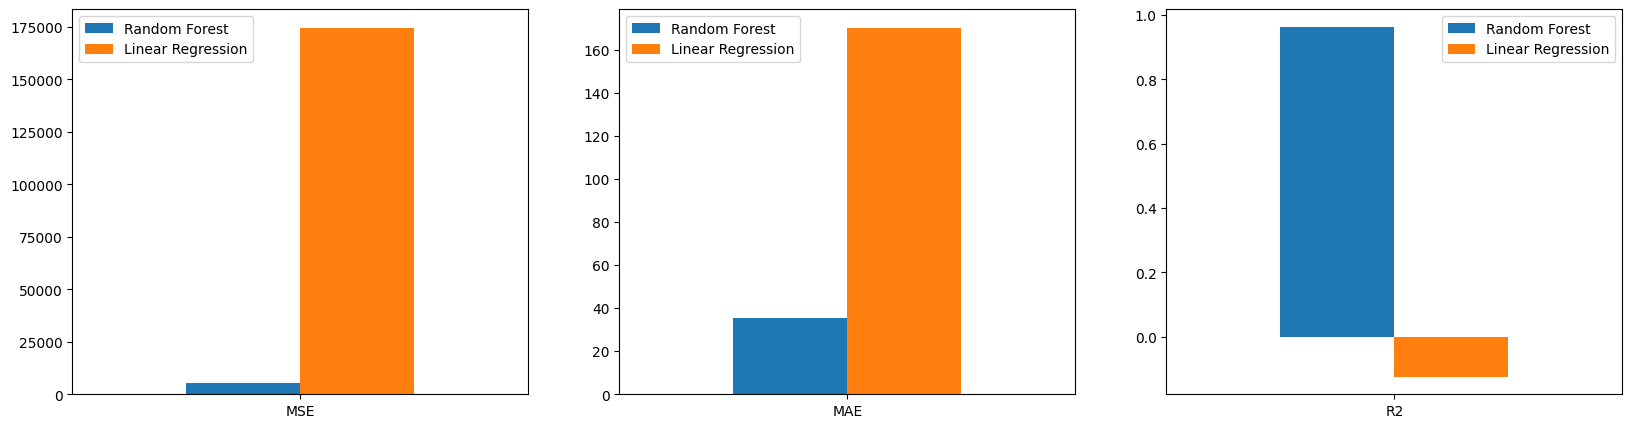

In [81]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This tests confirms that Random Forest is the better regression model with lower MSE and MAE and higher R2.

## Train a Final Model

Finally, we can train a Random Forest regression model with all the data we have, assuming that the more data we have the better the model.

In [89]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

We can also store this model on disk and deploy later within a software system.

In [92]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))